In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import os
import seaborn as sns
import anndata as ad
import scanpy as sc
import scanorama
from sklearn.model_selection import LeaveOneOut
import cycler

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.8.0 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.7


## Readin datasets from Puram and Cillo
### final adata is not final!

In [2]:
Puram_final_adata = sc.read_h5ad('./Puram/Puram_scanpy.h5ad')
Puram_final_adata.uns['log1p']["base"] = None
Puram_final_adata

AnnData object with n_obs × n_vars = 4484 × 21196
    obs: 'Cell_type', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors', 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [3]:
Puram_adata = sc.read_h5ad('./Puram/scanpy_qc_dr_Puram.h5ad')
Puram_adata.uns['log1p']["base"] = None
Puram_adata

AnnData object with n_obs × n_vars = 4484 × 5009
    obs: 'Cell_type', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
cillo_final_adata = sc.read_h5ad('./Cillo/Cillo_scanpy.h5ad')
cillo_final_adata.uns['log1p']["base"] = None
cillo_final_adata

AnnData object with n_obs × n_vars = 60171 × 23366
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'barcode', 'FItSNE_1', 'FItSNE_2', 'cell_type_annotations', 'patient_id'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors', 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
cillo_adata = sc.read_h5ad('./Cillo/scanpy_qc_dr_Cillo.h5ad')
cillo_adata.uns['log1p']["base"] = None
cillo_adata

AnnData object with n_obs × n_vars = 60171 × 1288
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'barcode', 'FItSNE_1', 'FItSNE_2', 'cell_type_annotations', 'patient_id'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type_annotations_colors', 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

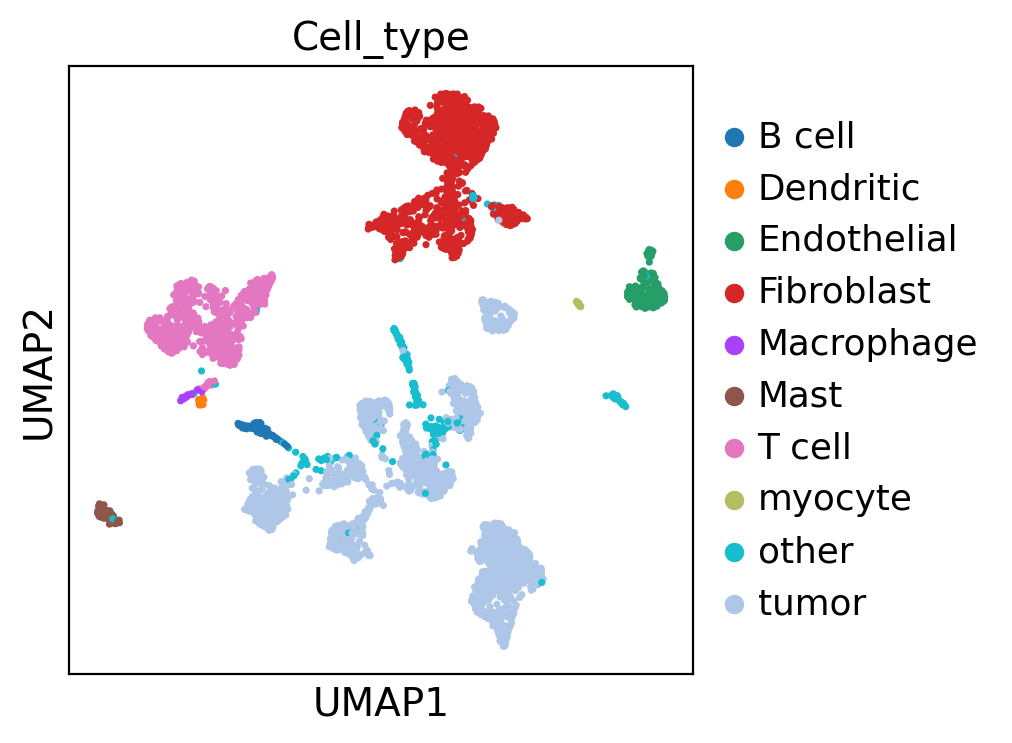

In [12]:
# dataset Puram 
sc.pl.umap(
    Puram_adata, color=["Cell_type"], )

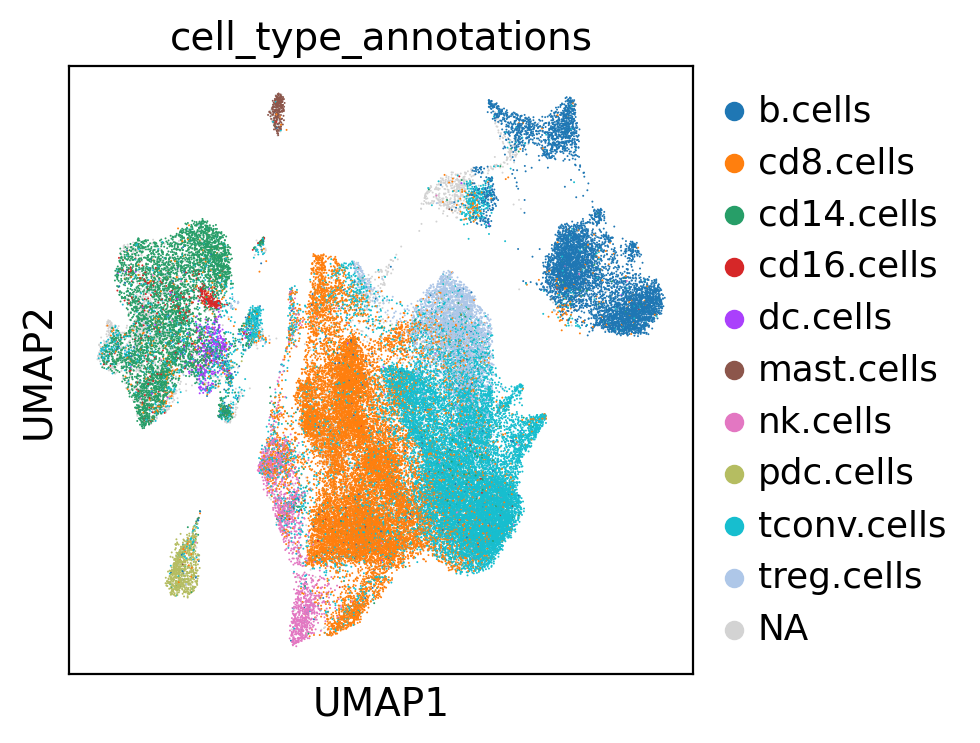

In [13]:
# ref data Cillo
sc.pl.umap(cillo_adata, color='cell_type_annotations')

In [91]:
common_celltypes = ['T cell', 'B cell', 'Dendritic', 'Mast', 'myocyte', 'other']

In [92]:
# Make sure we have the same genes in both datset by taking the intersection
adata_ref = cillo_adata.copy()
adata = Puram_adata.copy()
adata = adata[adata.obs['Cell_type'].isin(common_celltypes)] # we know there're no tumor in Cillo data

print(adata_ref.shape[1])
print(adata.shape[1])
var_names = adata_ref.var_names.intersection(adata.var_names)
print(len(var_names))

1288
5009
622


In [93]:
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [94]:
adata

View of AnnData object with n_obs × n_vars = 1145 × 622
    obs: 'Cell_type', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'tsne', 'umap', 'Cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:14)


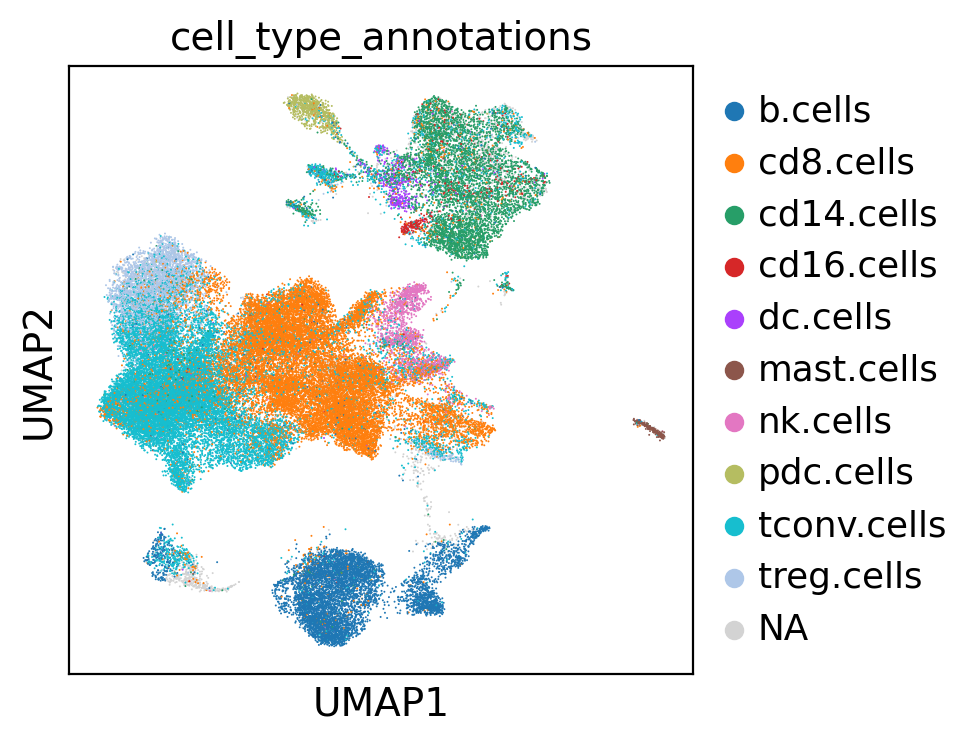

In [67]:
# First we need to rerun pca and umap with the same gene set for both datasets.
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color='cell_type_annotations')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


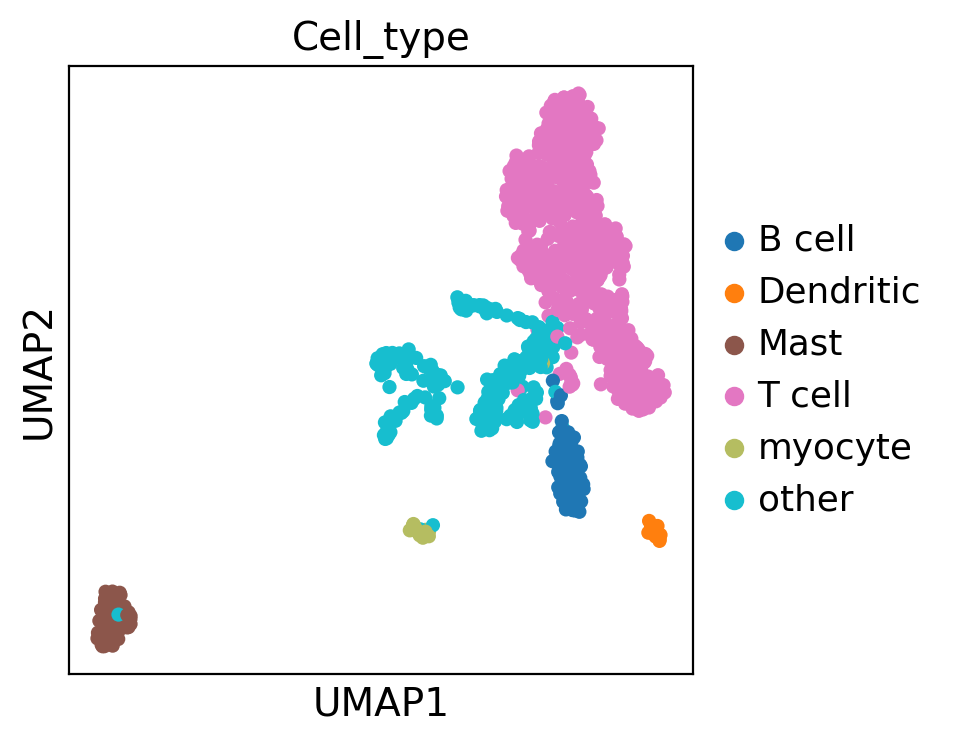

In [68]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='Cell_type')

## Integrate with harmony

In [95]:
import scanpy.external as sce

#subset the individual dataset to the same variable genes
alldata = dict()
alldata['ctrl']=adata

# adata_ref['Cell_type'] = adata_ref['cell_type_annotations']
alldata['ref']=adata_ref

#convert to list of AnnData objects
adatas = list(alldata.values())

# add in sample info
adata_ref.obs['sample'] = 'Cillo'
adata.obs['sample'] = 'Puram'

# create a merged scanpy object 
adata_merged = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample',
                                              batch_categories=['Puram','Cillo'])

adata_merged_2 = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample',
                                             batch_categories=['Puram','Cillo'])

/tmp/ipykernel_13973/3823046314.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ref.obs['sample'] = 'Cillo'
/tmp/ipykernel_13973/3823046314.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample'] = 'Puram'
/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtyp

In [96]:
# use multiple keys
# Harmony can integrate over multiple covariates. To do this, specify a vector covariates to integrate.

sce.pp.harmony_integrate(adata_merged, key = ['sample'])

2022-08-08 11:52:44,951 - harmonypy - INFO - Iteration 1 of 10
2022-08-08 11:53:38,936 - harmonypy - INFO - Iteration 2 of 10
2022-08-08 11:54:32,193 - harmonypy - INFO - Iteration 3 of 10
2022-08-08 11:55:25,635 - harmonypy - INFO - Iteration 4 of 10
2022-08-08 11:56:18,993 - harmonypy - INFO - Iteration 5 of 10
2022-08-08 11:57:09,080 - harmonypy - INFO - Iteration 6 of 10
2022-08-08 11:58:01,905 - harmonypy - INFO - Iteration 7 of 10
2022-08-08 11:58:47,189 - harmonypy - INFO - Iteration 8 of 10
2022-08-08 11:59:40,715 - harmonypy - INFO - Iteration 9 of 10
2022-08-08 12:00:26,070 - harmonypy - INFO - Iteration 10 of 10
2022-08-08 12:01:19,076 - harmonypy - INFO - Stopped before convergence


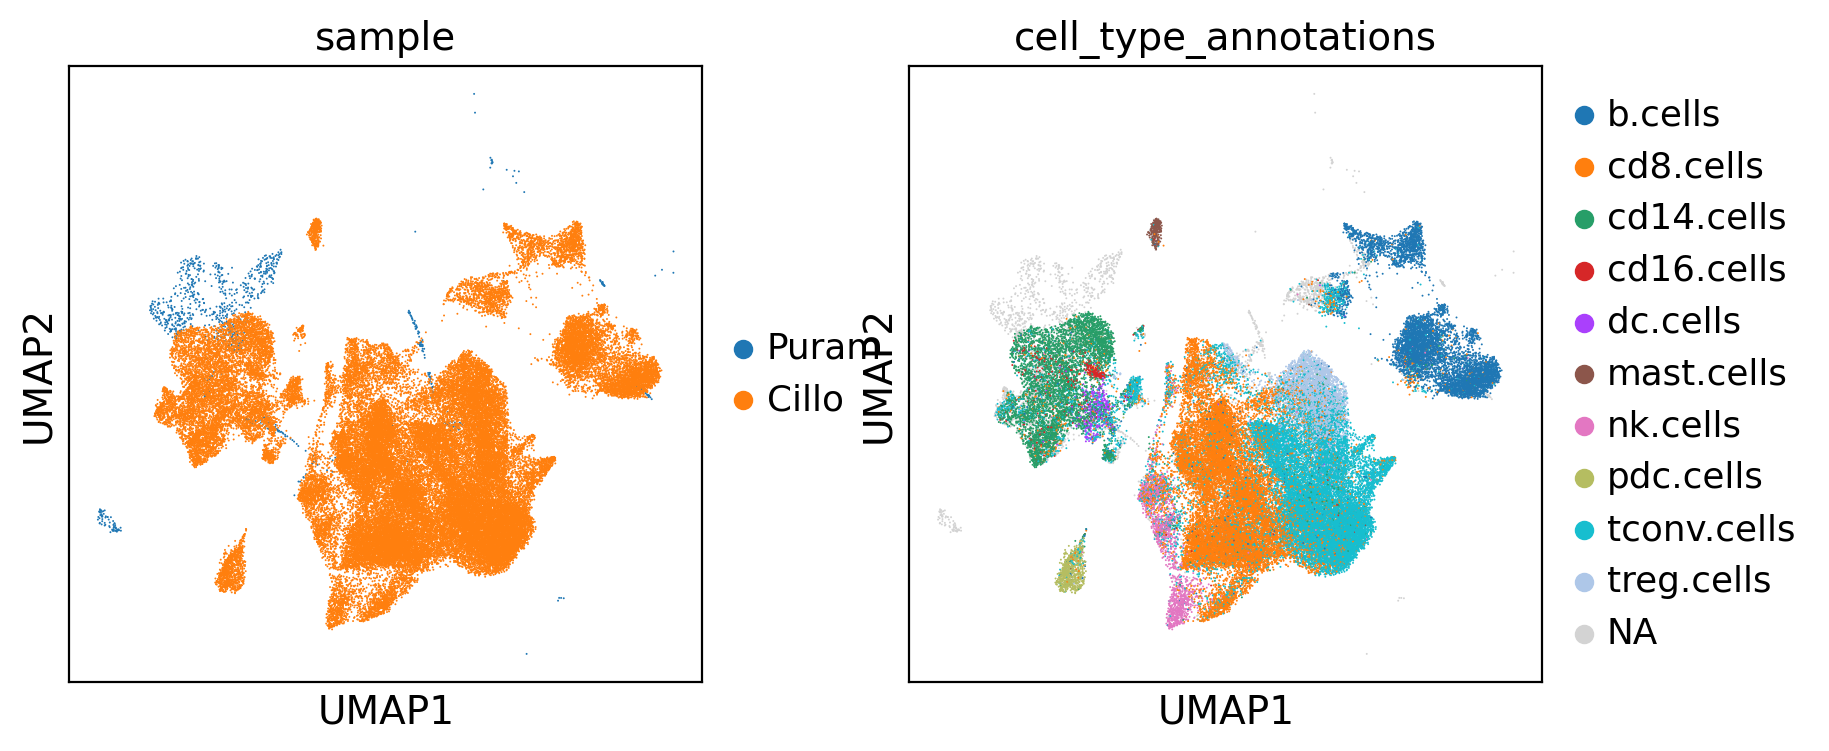

In [97]:
sc.pl.umap(adata_merged, color=["sample","cell_type_annotations"])

In [106]:
# use multiple keys
# Harmony can integrate over multiple covariates. To do this, specify a vector covariates to integrate.

sce.pp.harmony_integrate(adata_merged_2, key = ['sample','batch'])

2022-08-08 12:06:23,099 - harmonypy - INFO - Iteration 1 of 10
2022-08-08 12:07:20,357 - harmonypy - INFO - Iteration 2 of 10
2022-08-08 12:08:19,895 - harmonypy - INFO - Iteration 3 of 10
2022-08-08 12:09:16,993 - harmonypy - INFO - Iteration 4 of 10
2022-08-08 12:10:16,494 - harmonypy - INFO - Iteration 5 of 10
2022-08-08 12:11:06,231 - harmonypy - INFO - Iteration 6 of 10
2022-08-08 12:12:05,518 - harmonypy - INFO - Iteration 7 of 10
2022-08-08 12:12:57,575 - harmonypy - INFO - Converged after 7 iterations


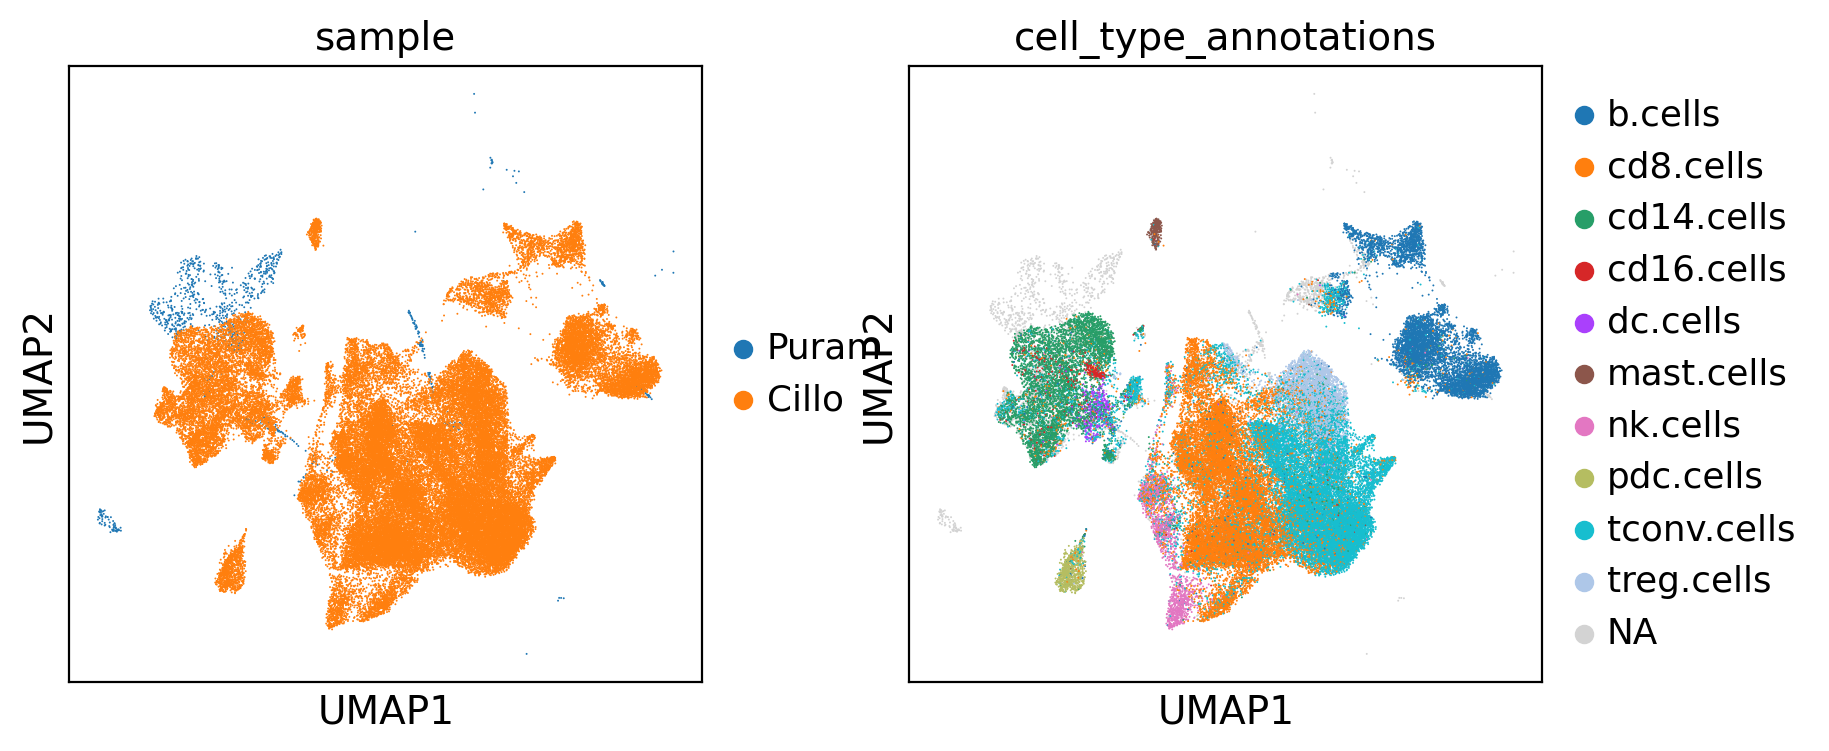

In [107]:
sc.pl.umap(adata_merged_2, color=["sample","cell_type_annotations",])

In [108]:
# Label transfer
# Using the function in the Spatial tutorial at the scanpy website we will 
# calculate normalized cosine distances between the two datasets and tranfer labels to the celltype with the highest scores.

from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    adata_merged_2[adata_merged_2.obs['sample'] == "Cillo"].obsm["X_pca_harmony"],
    adata_merged_2[adata_merged_2.obs['sample'] == "Puram"].obsm["X_pca_harmony"],
)

def label_transfer(dist, labels, index):
    lab = pd.get_dummies(labels)
    class_prob = lab.to_numpy().T @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    # convert to df
    cp_df = pd.DataFrame(
        class_prob, columns=lab.columns
    )
    cp_df.index = index
    # classify as max score
    m = cp_df.idxmax(axis=1)
    
    return m

In [109]:
class_def = label_transfer(distances, adata_ref.obs.cell_type_annotations, adata.obs.index)
# add to obs section of the original object
adata.obs['HarmonyDistance'] = class_def

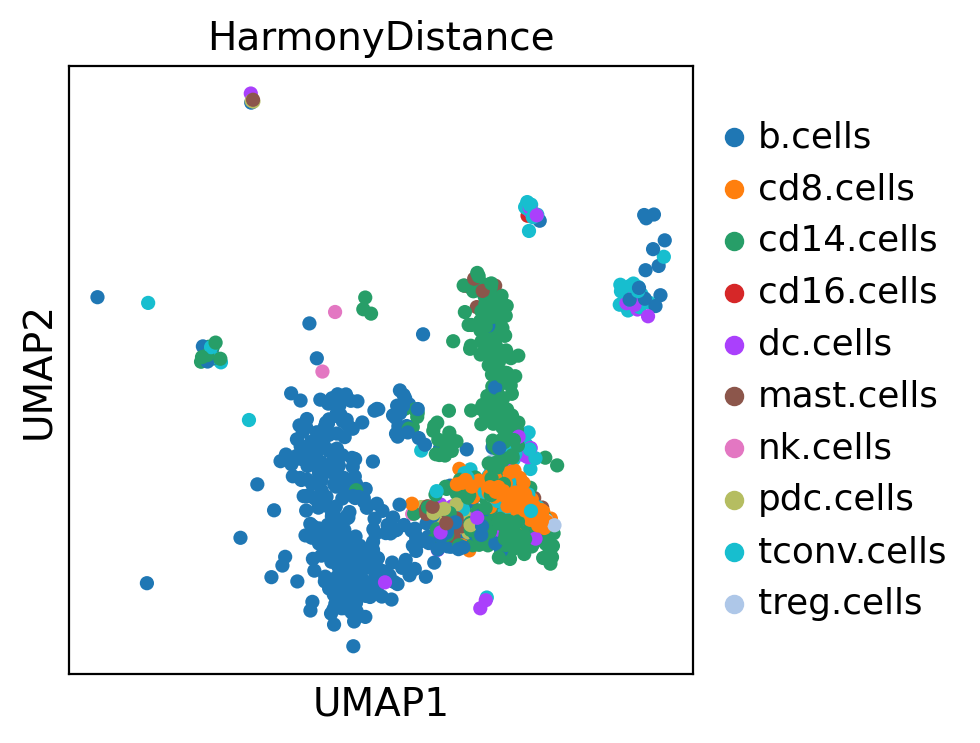

In [110]:
sc.pl.umap(adata, color="HarmonyDistance")

/tmp/ipykernel_13973/1369959678.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adata_merged_2.obs['HarmonyDistance'] = class_def.append(adata_ref.obs['cell_type_annotations']).tolist()


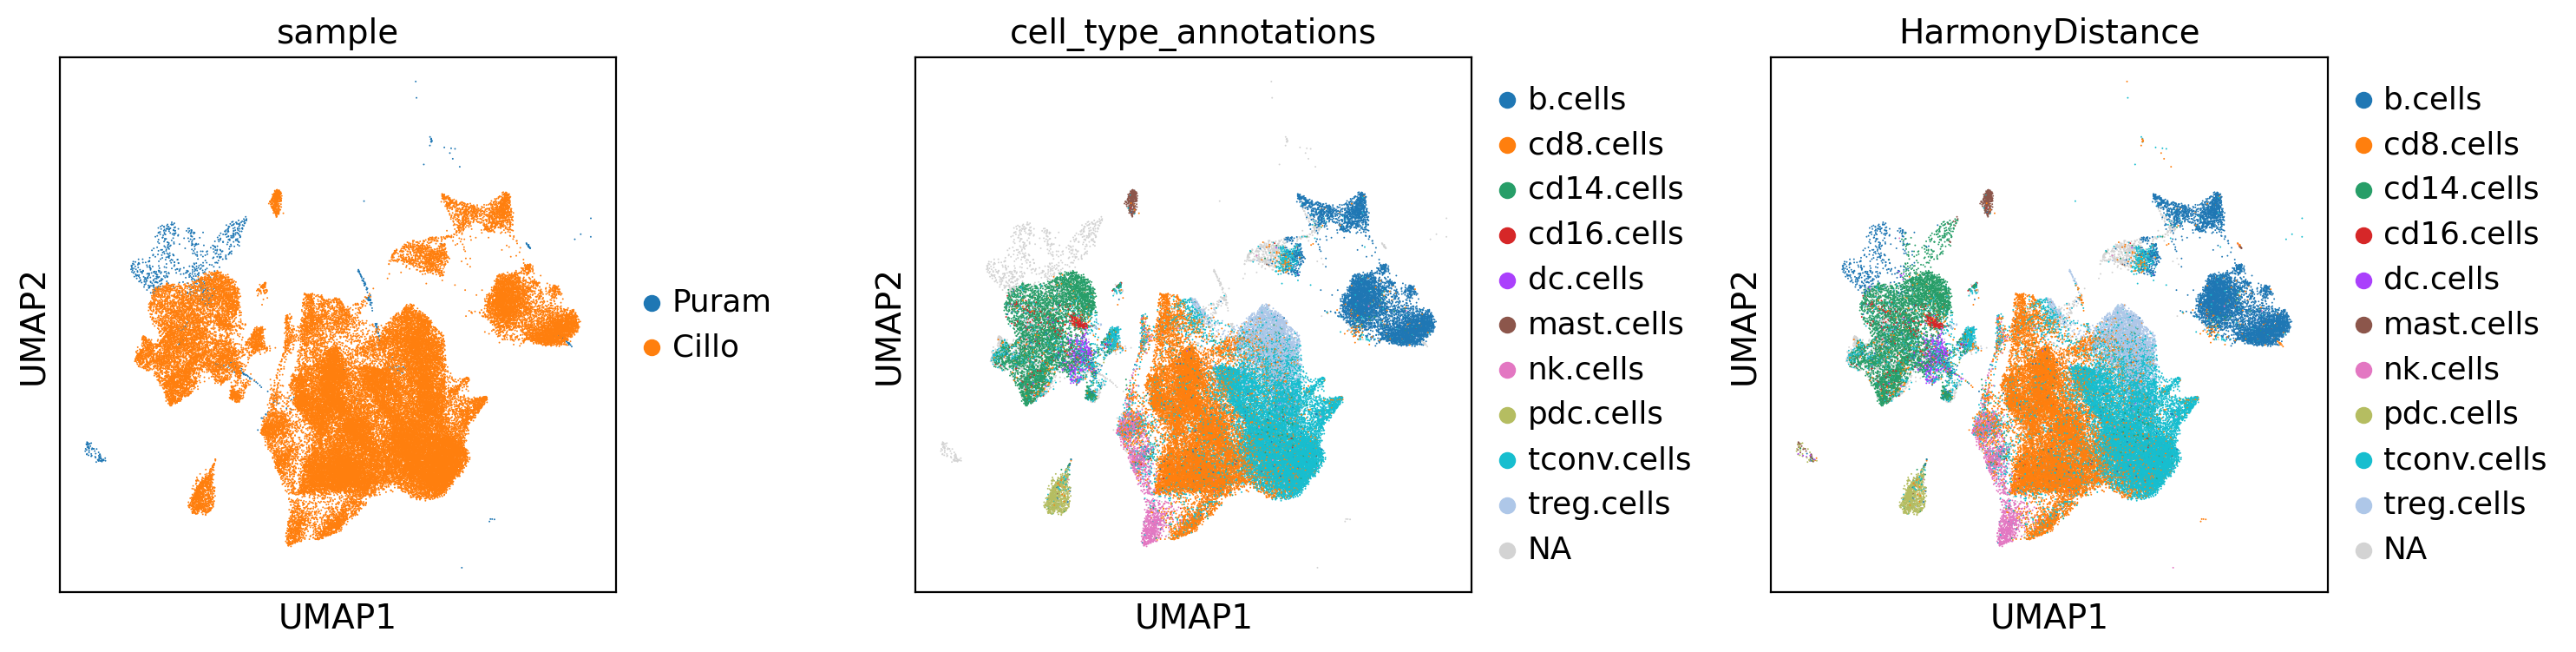

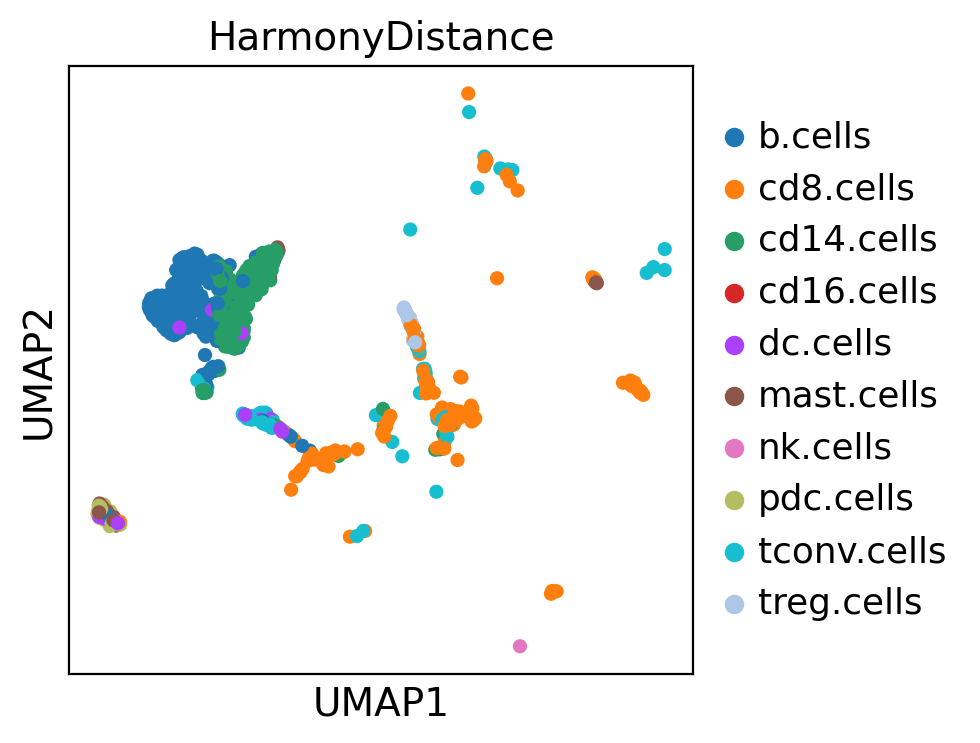

In [111]:
# add to merged object.
adata_merged_2.obs['HarmonyDistance'] = class_def.append(adata_ref.obs['cell_type_annotations']).tolist()

sc.pl.umap(adata_merged_2, color=["sample","cell_type_annotations",'HarmonyDistance'],wspace=0.4)

#plot only ctrl cells.
sc.pl.umap(adata_merged_2[adata_merged_2.obs['sample']=='Puram'], color='HarmonyDistance')

## Integrate with Ingest

running ingest
    finished (0:00:07)


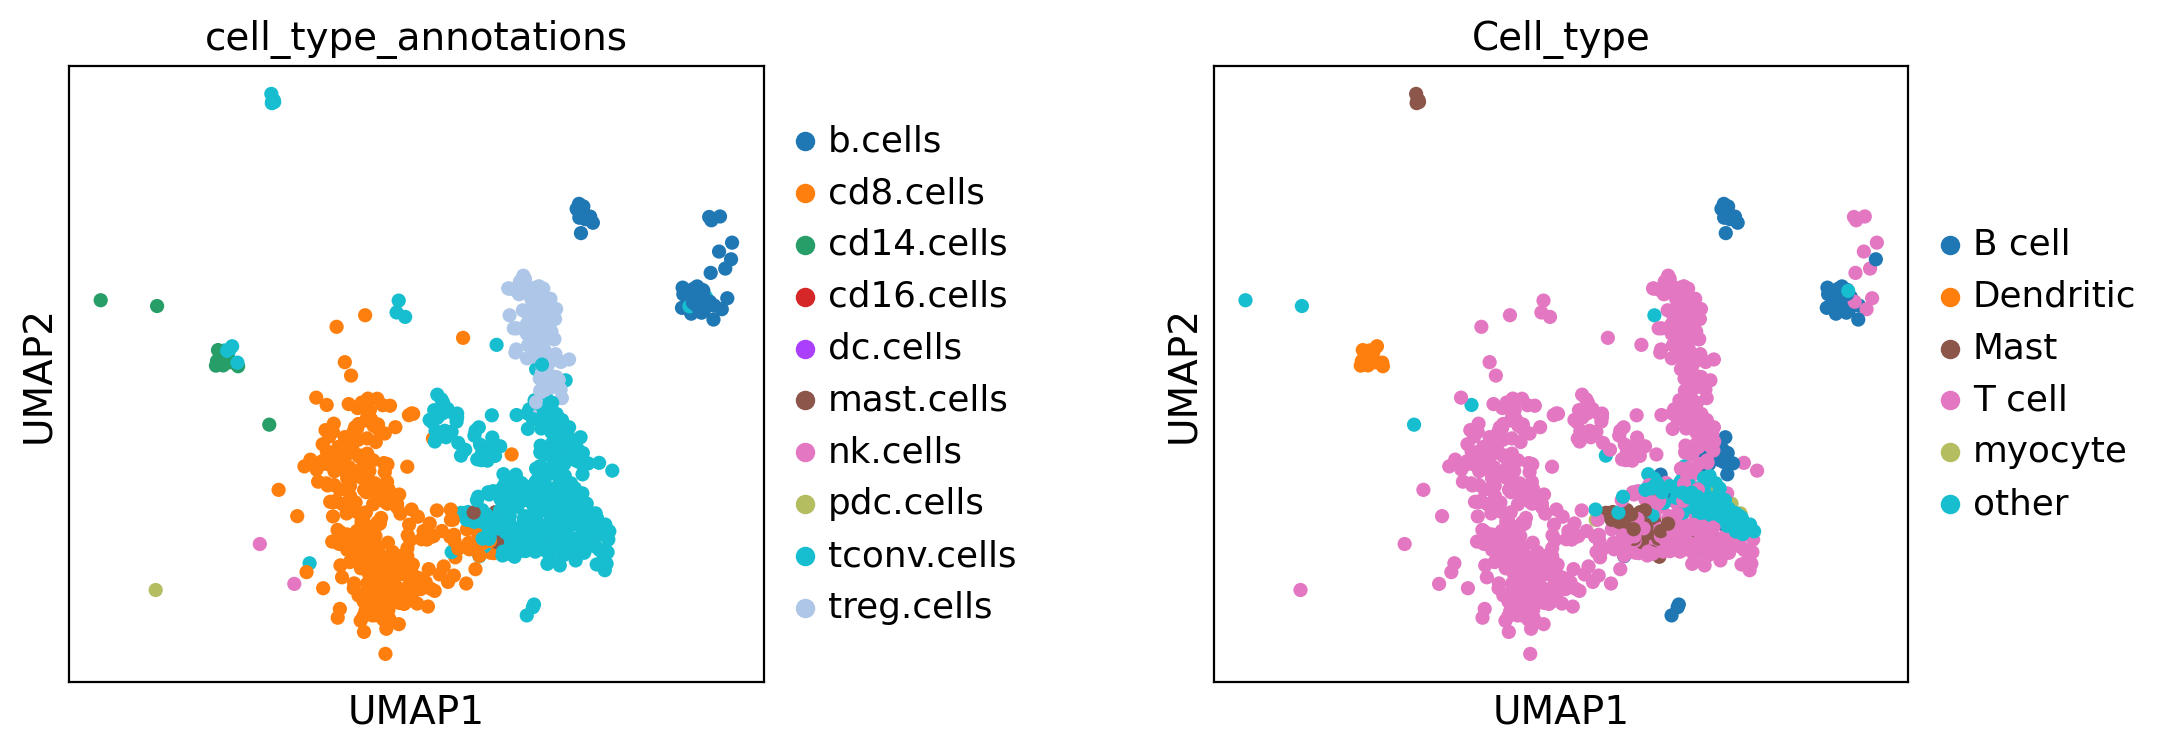

In [112]:
sc.tl.ingest(adata, adata_ref, obs='cell_type_annotations')

sc.pl.umap(adata, color=['cell_type_annotations','Cell_type'], wspace=0.5)

## Compare Results
The predictions from ingest is stored in the column 'cell_type_annotations' while we named the label transfer with harmony as 'HarmonyDistance'



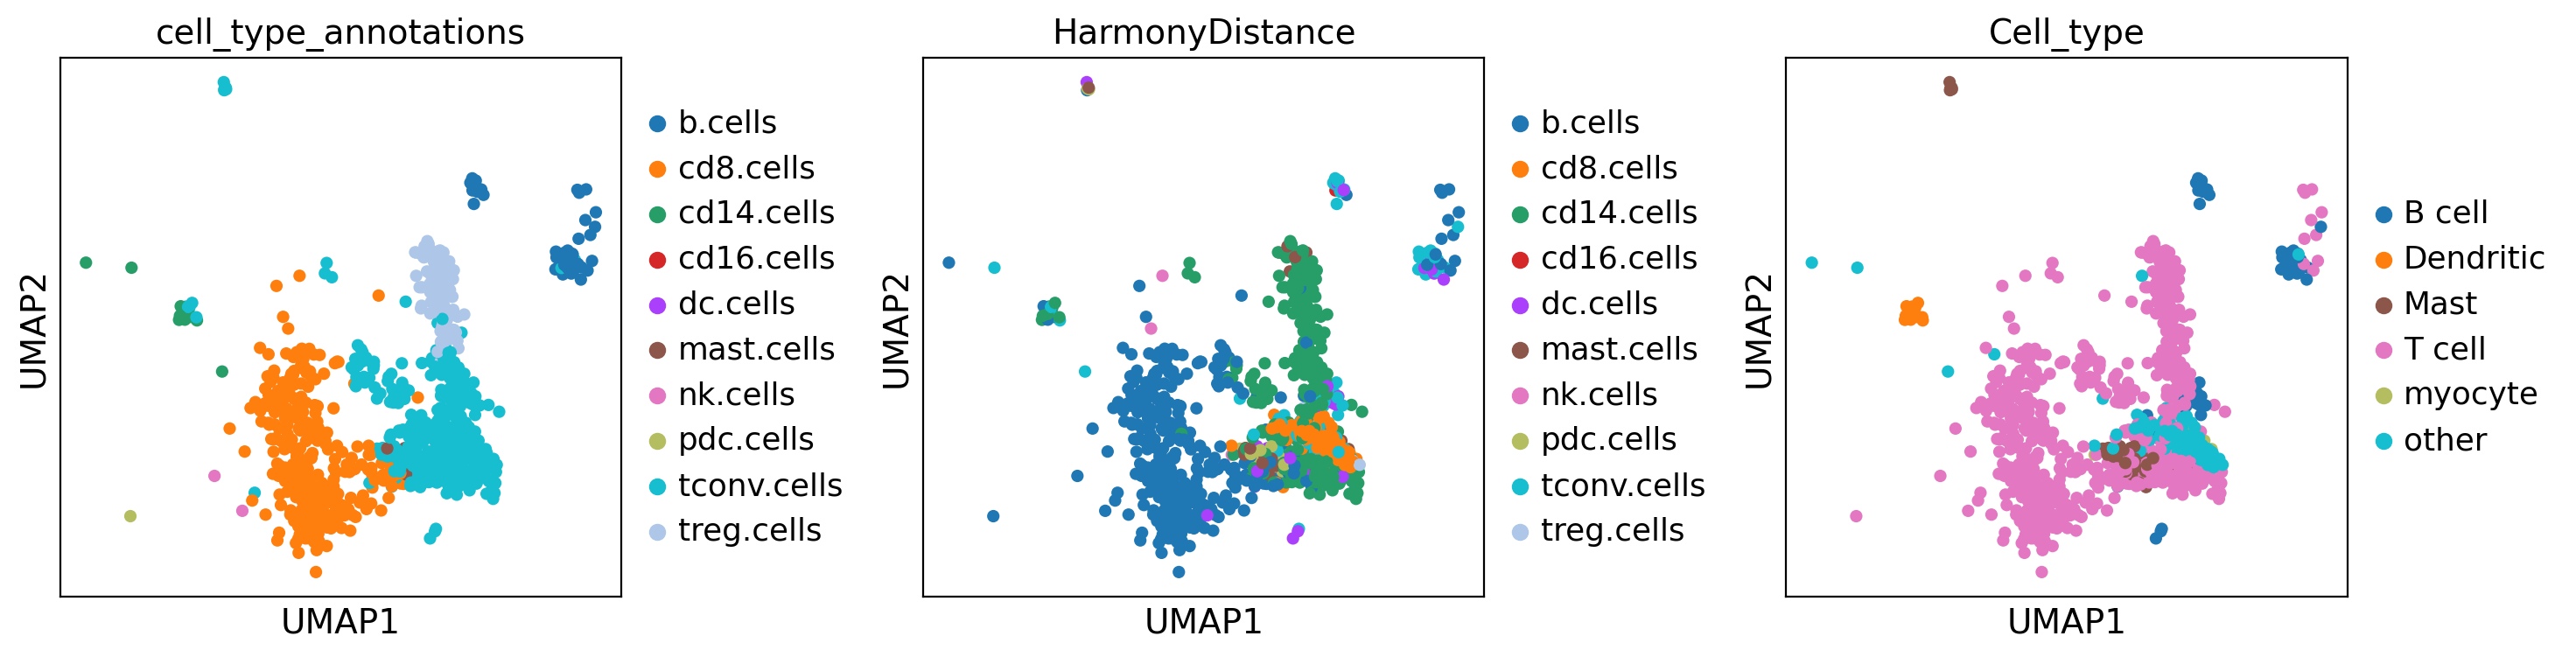

In [141]:
sc.pl.umap(adata, color=['cell_type_annotations','HarmonyDistance','Cell_type'], wspace=0.4)

In [116]:
#save to file
save_file_merged = './Puram/scanpy_Puram_imputed.h5ad'
adata.write_h5ad(save_file_merged)

## Extract immune subtypes from Ingest predictions

In [117]:
adata.obs[adata.obs['HarmonyDistance']==adata.obs['cell_type_annotations']]
#only 80 concensus resutls

Cell_type batch  n_genes_by_counts  total_counts  \
HN25_P5_B04_S16_comb           other    25               4076  1.000005e+06   
HN25_P24_B12_S120_comb        T cell    25               2430  1.000011e+06   
HN25_P25_B08_S308_comb     Dendritic    25               2393  9.999795e+05   
HN26_P13_G06_S174_comb        B cell    26               2794  1.000013e+06   
HN25_P5_H12_S96_comb           other    25               6202  9.999926e+05   
...                              ...   ...                ...           ...   
HNSCC16_P7_HNSCC16_P7_F02      other    16               5571  1.000036e+06   
HNSCC6_p13_hnscc6_p13_E03      other     6               3803  9.999959e+05   
HNSCC6_p14_hnscc6_p14_B07      other     6               2468  9.999945e+05   
HNSCC6_p8_HNSCC6_P8_H12        other     6              14258  1.000001e+06   
HNSCC17_P4_F08_S164_comb       other    17               3904  1.000007e+06   

                           total_counts_mt  pct_counts_mt  total_counts_ribo  \
HN25_P5_B04_S16_comb                   0.0            0.0      111071.195312   
HN25_P24_B12_S120_comb                 0.0            0.0      166504.921875   
HN25_P25_B08_S308_comb                 0.0            0.0       82495.257812   
HN26_P13_G06_S174_comb                 0.0            0.0      116527.828125   
HN25_P5_H12_S96_comb                   0.0            0.0      263524.625000   
...                                    ...            ...                ...   
HNSCC16_P7_HNSCC16_P7_F02              0.0            0.0       94434.796875   
HNSCC6_p13_hnscc6_p13_E03              0.0            0.0      106610.250000   
HNSCC6_p14_hnscc6_p14_B07              0.0            0.0      155370.265625   
HNSCC6_p8_HNSCC6_P8_H12                0.0            0.0      159348.515625   
HNSCC17_P4_F08_S164_comb               0.0            0.0       75785.601562   

                           pct_counts_ribo  total_counts_hb  pct_counts_hb  \
HN25_P5_B04_S16_comb             11.107064       156.099411       0.015610   
HN25_P24_B12_S120_comb           16.650312         0.000000       0.000000   
HN25_P25_B08_S308_comb            8.249695         0.000000       0.000000   
HN26_P13_G06_S174_comb           11.652627         0.000000       0.000000   
HN25_P5_H12_S96_comb             26.352659      1240.756592       0.124077   
...                                    ...              ...            ...   
HNSCC16_P7_HNSCC16_P7_F02         9.443135         0.000000       0.000000   
HNSCC6_p13_hnscc6_p13_E03        10.661069         0.000000       0.000000   
HNSCC6_p14_hnscc6_p14_B07        15.537111         0.000000       0.000000   
HNSCC6_p8_HNSCC6_P8_H12          15.934834        52.501633       0.005250   
HNSCC17_P4_F08_S164_comb          7.578508         0.000000       0.000000   

                           percent_mt2     n_counts  n_genes  doublet_scores  \
HN25_P5_B04_S16_comb               0.0  999548.0000     4076        0.009037   
HN25_P24_B12_S120_comb             0.0  995146.6250     2430        0.022758   
HN25_P25_B08_S308_comb             0.0  989105.4375     2393        0.020045   
HN26_P13_G06_S174_comb             0.0  997289.5000     2794        0.005546   
HN25_P5_H12_S96_comb               0.0  997789.3125     6202        0.001933   
...                                ...          ...      ...             ...   
HNSCC16_P7_HNSCC16_P7_F02          0.0  997520.8750     5571        0.141618   
HNSCC6_p13_hnscc6_p13_E03          0.0  999372.4375     3803        0.018877   
HNSCC6_p14_hnscc6_p14_B07          0.0  976299.0000     2468        0.007643   
HNSCC6_p8_HNSCC6_P8_H12            0.0  998983.6250    14258        0.009037   
HNSCC17_P4_F08_S164_comb           0.0  988709.4375     3904        0.001094   

                           predicted_doublets doublet_info sample  \
HN25_P5_B04_S16_comb                    False        False  Puram   
HN25_P24_B12_S120_comb                  False        False  Puram   
HN25_P25_B08

In [119]:
df_merged_puram = pd.merge(Puram_final_adata.obs,adata.obs,left_index=True,right_index=True,how='left')
df_merged_puram

Cell_type_x batch_x  n_genes_by_counts_x  \
HN28_P15_D06_S330_comb     Fibroblast      28                 4286   
HN28_P6_G05_S173_comb      Fibroblast      28                 2723   
HN26_P14_D11_S239_comb          tumor      26                 6965   
HN26_P14_H05_S281_comb     Fibroblast      26                 3451   
HN26_P25_H09_S189_comb          tumor      26                 7355   
...                               ...     ...                  ...   
HNSCC17_P4_G12_S180_comb        other      17                 4801   
HNSCC20_P13_C05_S221_comb       tumor      20                 5788   
HNSCC17_P4_C12_S132_comb        tumor      17                 5375   
HNSCC20_P3_H08_S92_comb         tumor      20                 5666   
HNSCC20_P3_G06_S78_comb         tumor      20                 5653   

                           total_counts_x  total_counts_mt_x  pct_counts_mt_x  \
HN28_P15_D06_S330_comb       1.000009e+06                0.0              0.0   
HN28_P6_G05_S173_comb        1.000014e+06                0.0              0.0   
HN26_P14_D11_S239_comb       9.999924e+05                0.0              0.0   
HN26_P14_H05_S281_comb       1.000007e+06                0.0              0.0   
HN26_P25_H09_S189_comb       1.000015e+06                0.0              0.0   
...                                   ...                ...              ...   
HNSCC17_P4_G12_S180_comb     1.000001e+06                0.0              0.0   
HNSCC20_P13_C05_S221_comb    1.000003e+06                0.0              0.0   
HNSCC17_P4_C12_S132_comb     9.999812e+05                0.0              0.0   
HNSCC20_P3_H08_S92_comb      1.000019e+06                0.0              0.0   
HNSCC20_P3_G06_S78_comb      1.000011e+06                0.0              0.0   

                           total_counts_ribo_x  pct_counts_ribo_x  \
HN28_P15_D06_S330_comb            86613.296875           8.661255   
HN28_P6_G05_S173_comb            149693.578125          14.969142   
HN26_P14_D11_S239_comb           186097.953125          18.609936   
HN26_P14_H05_S281_comb           132006.796875          13.200584   
HN26_P25_H09_S189_comb           187427.015625          18.742414   
...                                        ...                ...   
HNSCC17_P4_G12_S180_comb          88164.929688           8.816483   
HNSCC20_P13_C05_S221_comb        125418.648438          12.541826   
HNSCC17_P4_C12_S132_comb         113774.828125          11.377696   
HNSCC20_P3_H08_S92_comb           86069.804688           8.606817   
HNSCC20_P3_G06_S78_comb           93712.046875           9.371105   

                           total_counts_hb_x  pct_counts_hb_x  ...  \
HN28_P15_D06_S330_comb             76.009735         0.007601  ...   
HN28_P6_G05_S173_comb               0.000000         0.000000  ...   
HN26_P14_D11_S239_comb             48.559368         0.004856  ...   
HN26_P14_H05_S281_comb              1.369982         0.000137  ...   
HN26_P25_H09_S189_comb             40.318760         0.004032  ...   
...                                      ...              ...  ...   
HNSCC17_P4_G12_S180_comb            0.000000         0.000000  ...   
HNSCC20_P13_C05_S221_comb           0.000000         0.000000  ...   
HNSCC17_P4_C12_S132_comb           40.110050         0.004011  ...   
HNSCC20_P3_H08_S92_comb             0.000000         0.000000  ...   
HNSCC20_P3_G06_S78_comb             3.470001         0.000347  ...   

                           pct_counts_hb_y  percent_mt2_y   n_counts_y  \
HN28_P15_D06_S330_comb                 NaN            NaN          NaN   
HN28_P6_G05_S173_comb                  NaN            NaN          NaN   
HN26_P14_D11_S239_comb                 NaN            NaN          NaN   
HN26_P14_H05_S281_comb                 NaN            NaN          NaN   
HN26_P25_H09_S189_comb                 NaN            NaN          NaN   
...                                    ...            ...          ...   
HNSCC17_P4_G12_S180_comb

In [142]:
Puram_final_adata.obs['Ingest_prediction'] = df_merged_puram['cell_type_annotations'].tolist()

In [151]:
Puram_final_adata.obs.loc[Puram_final_adata.obs['Ingest_prediction'].isnull(),'Ingest_prediction'] = Puram_final_adata.obs['Cell_type']

We need to reset Puram major cell types used to BayesPrism deconvolution because for some subtypes it maps to more than one major cell types, since they are predicted, this is well within expectation. But we need to modify the major cell types to get BP running. 

In [156]:
Puram_final_adata.obs.loc[:,'Ingest_prediction'].value_counts()

tumor          2019
Fibroblast     1144
tconv.cells     625
cd8.cells       339
Endothelial     154
treg.cells      114
b.cells          48
Macrophage       22
cd14.cells       13
mast.cells        3
nk.cells          2
pdc.cells         1
Name: Ingest_prediction, dtype: int64

In [166]:
Puram_final_adata.obs.loc[Puram_final_adata.obs['Ingest_prediction']=='tconv.cells','Cell_type']='T cell'

In [167]:
Puram_final_adata.obs[Puram_final_adata.obs['Ingest_prediction']=='tconv.cells']['Cell_type'].value_counts()

T cell         625
B cell           0
Dendritic        0
Endothelial      0
Fibroblast       0
Macrophage       0
Mast             0
myocyte          0
other            0
tumor            0
Name: Cell_type, dtype: int64

In [168]:
Puram_final_adata.obs.loc[Puram_final_adata.obs['Ingest_prediction']=='cd8.cells','Cell_type']='T cell'

In [169]:
Puram_final_adata.obs[Puram_final_adata.obs['Ingest_prediction']=='cd8.cells']['Cell_type'].value_counts()

T cell         339
B cell           0
Dendritic        0
Endothelial      0
Fibroblast       0
Macrophage       0
Mast             0
myocyte          0
other            0
tumor            0
Name: Cell_type, dtype: int64

In [170]:
Puram_final_adata.obs.loc[Puram_final_adata.obs['Ingest_prediction']=='treg.cells','Cell_type']='T cell'

In [171]:
Puram_final_adata.obs[Puram_final_adata.obs['Ingest_prediction']=='treg.cells']['Cell_type'].value_counts()

T cell         114
B cell           0
Dendritic        0
Endothelial      0
Fibroblast       0
Macrophage       0
Mast             0
myocyte          0
other            0
tumor            0
Name: Cell_type, dtype: int64

In [172]:
Puram_final_adata.obs.loc[Puram_final_adata.obs['Ingest_prediction']=='b.cells','Cell_type']='B cell'

In [173]:
Puram_final_adata.obs[Puram_final_adata.obs['Ingest_prediction']=='b.cells']['Cell_type'].value_counts()

B cell         48
Dendritic       0
Endothelial     0
Fibroblast      0
Macrophage      0
Mast            0
T cell          0
myocyte         0
other           0
tumor           0
Name: Cell_type, dtype: int64

In [175]:
Puram_final_adata.obs.loc[Puram_final_adata.obs['Ingest_prediction']=='cd14.cells','Cell_type']='other'

In [176]:
Puram_final_adata.obs[Puram_final_adata.obs['Ingest_prediction']=='cd14.cells']['Cell_type'].value_counts()

other          13
B cell          0
Dendritic       0
Endothelial     0
Fibroblast      0
Macrophage      0
Mast            0
T cell          0
myocyte         0
tumor           0
Name: Cell_type, dtype: int64

In [178]:
Puram_final_adata.obs.loc[Puram_final_adata.obs['Ingest_prediction']=='mast.cells','Cell_type']='Mast'

In [179]:
Puram_final_adata.obs[Puram_final_adata.obs['Ingest_prediction']=='mast.cells']['Cell_type'].value_counts()

Mast           3
B cell         0
Dendritic      0
Endothelial    0
Fibroblast     0
Macrophage     0
T cell         0
myocyte        0
other          0
tumor          0
Name: Cell_type, dtype: int64

In [181]:
Puram_final_adata.obs

Cell_type batch  n_genes_by_counts  total_counts  \
HN28_P15_D06_S330_comb     Fibroblast    28               4286  1.000009e+06   
HN28_P6_G05_S173_comb      Fibroblast    28               2723  1.000014e+06   
HN26_P14_D11_S239_comb          tumor    26               6965  9.999924e+05   
HN26_P14_H05_S281_comb     Fibroblast    26               3451  1.000007e+06   
HN26_P25_H09_S189_comb          tumor    26               7355  1.000015e+06   
...                               ...   ...                ...           ...   
HNSCC17_P4_G12_S180_comb       T cell    17               4801  1.000001e+06   
HNSCC20_P13_C05_S221_comb       tumor    20               5788  1.000003e+06   
HNSCC17_P4_C12_S132_comb        tumor    17               5375  9.999812e+05   
HNSCC20_P3_H08_S92_comb         tumor    20               5666  1.000019e+06   
HNSCC20_P3_G06_S78_comb         tumor    20               5653  1.000011e+06   

                           total_counts_mt  pct_counts_mt  total_counts_ribo  \
HN28_P15_D06_S330_comb                 0.0            0.0       86613.296875   
HN28_P6_G05_S173_comb                  0.0            0.0      149693.578125   
HN26_P14_D11_S239_comb                 0.0            0.0      186097.953125   
HN26_P14_H05_S281_comb                 0.0            0.0      132006.796875   
HN26_P25_H09_S189_comb                 0.0            0.0      187427.015625   
...                                    ...            ...                ...   
HNSCC17_P4_G12_S180_comb               0.0            0.0       88164.929688   
HNSCC20_P13_C05_S221_comb              0.0            0.0      125418.648438   
HNSCC17_P4_C12_S132_comb               0.0            0.0      113774.828125   
HNSCC20_P3_H08_S92_comb                0.0            0.0       86069.804688   
HNSCC20_P3_G06_S78_comb                0.0            0.0       93712.046875   

                           pct_counts_ribo  total_counts_hb  pct_counts_hb  \
HN28_P15_D06_S330_comb            8.661255        76.009735       0.007601   
HN28_P6_G05_S173_comb            14.969142         0.000000       0.000000   
HN26_P14_D11_S239_comb           18.609936        48.559368       0.004856   
HN26_P14_H05_S281_comb           13.200584         1.369982       0.000137   
HN26_P25_H09_S189_comb           18.742414        40.318760       0.004032   
...                                    ...              ...            ...   
HNSCC17_P4_G12_S180_comb          8.816483         0.000000       0.000000   
HNSCC20_P13_C05_S221_comb        12.541826         0.000000       0.000000   
HNSCC17_P4_C12_S132_comb         11.377696        40.110050       0.004011   
HNSCC20_P3_H08_S92_comb           8.606817         0.000000       0.000000   
HNSCC20_P3_G06_S78_comb           9.371105         3.470001       0.000347   

                           percent_mt2     n_counts  n_genes  doublet_scores  \
HN28_P15_D06_S330_comb             0.0  998772.7500     4286        0.001839   
HN28_P6_G05_S173_comb              0.0  998379.7500     2723        0.001245   
HN26_P14_D11_S239_comb             0.0  999708.2500     6965        0.000950   
HN26_P14_H05_S281_comb             0.0  998924.0000     3451        0.004927   
HN26_P25_H09_S189_comb             0.0  999479.3750     7355        0.000880   
...                                ...          ...      ...             ...   
HNSCC17_P4_G12_S180_comb           0.0  996694.6875     4801        0.006500   
HNSCC20_P13_C05_S221_comb          0.0  997012.5000     5788        0.003883   
HNSCC17_P4_C12_S132_comb           0.0  999734.4375     5375        0.002911   
HNSCC20_P3_H08_S92_comb            0.0  998648.0625     5666        0.001572   
HNSCC20_P3_G06_S78_comb            0.0  999388.0625     5653        0.001324   

                           predicted_doublets doublet_info Ingest_prediction  
HN28_P15_D06_S330_comb                  False        False        Fibroblast  
HN28_P6_G05_S173_comb                   False     

In [183]:
Puram_final_adata.obs.loc[:,'Cell_type'].to_csv("/home/cke/Puram/scRNAlabels/cellcategory_simple_corrected.csv")
Puram_final_adata.obs.loc[:,'Ingest_prediction'].to_csv("/home/cke/Puram/scRNAlabels/cellcategory_subtype.csv")

In [185]:
Puram_final_adata

AnnData object with n_obs × n_vars = 4484 × 21196
    obs: 'Cell_type', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'Ingest_prediction'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors', 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [154]:
results_file = './Puram/Puram_scanpy_subtypes.h5ad'  # the file that will store the analysis results
Puram_final_adata.write_h5ad(results_file)

... storing 'Ingest_prediction' as categorical


In [124]:
df_merged_puram['Cell_type_y'].value_counts()

T cell       726
other        248
B cell        71
Mast          64
myocyte       19
Dendritic     17
Name: Cell_type_y, dtype: int64

In [122]:
df_merged_puram['HarmonyDistance'].value_counts()

b.cells        415
cd14.cells     333
cd8.cells      175
tconv.cells     89
mast.cells      41
dc.cells        37
pdc.cells       28
treg.cells      23
nk.cells         3
cd16.cells       1
Name: HarmonyDistance, dtype: int64

In [121]:
df_merged_puram['cell_type_annotations'].value_counts()

tconv.cells    625
cd8.cells      339
treg.cells     114
b.cells         48
cd14.cells      13
mast.cells       3
nk.cells         2
pdc.cells        1
cd16.cells       0
dc.cells         0
Name: cell_type_annotations, dtype: int64

### Reference: CellMarker Gene set overlaps

In [125]:
# run differential expression per cluster
sc.tl.rank_genes_groups(adata, 'Cell_type', method='wilcoxon', key_added = "wilcoxon")

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


In [126]:
# Cell markers of different cell types from different tissues in human.
df = pd.read_table("/home/cke/Human_cell_markers.txt")
df

speciesType          tissueType UberonOntologyID         cancerType  \
0          Human              Kidney   UBERON_0002113             Normal   
1          Human               Liver   UBERON_0002107             Normal   
2          Human         Endometrium   UBERON_0001295             Normal   
3          Human                Germ   UBERON_0000923             Normal   
4          Human  Corneal epithelium   UBERON_0001772             Normal   
...          ...                 ...              ...                ...   
2863       Human              Embryo   UBERON_0000922             Normal   
2864       Human              Embryo   UBERON_0000922             Normal   
2865       Human              Embryo   UBERON_0000922             Normal   
2866       Human              Embryo   UBERON_0000922             Normal   
2867       Human               Brain   UBERON_0000955  oligodendroglioma   

         cellType                          cellName CellOntologyID  \
0     Normal cell             Proximal tubular cell            NaN   
1     Normal cell  Ito cell (hepatic stellate cell)     CL_0000632   
2     Normal cell                  Trophoblast cell     CL_0000351   
3     Normal cell              Primordial germ cell     CL_0000670   
4     Normal cell                   Epithelial cell     CL_0000066   
...           ...                               ...            ...   
2863  Normal cell    1-cell stage cell (Blastomere)     CL_0000353   
2864  Normal cell    4-cell stage cell (Blastomere)     CL_0000353   
2865  Normal cell    8-cell stage cell (Blastomere)     CL_0000353   
2866  Normal cell          Morula cell (Blastomere)     CL_0000360   
2867  Cancer cell                  Cancer stem cell            NaN   

                                             cellMarker  \
0                       Intestinal Alkaline Phosphatase   
1                                         Synaptophysin   
2                                               CEACAM1   
3                                                  VASA   
4                                                  KLF6   
...                                                 ...   
2863  ACCSL, ACVR1B, ARHGEF16, ASF1B, BCL2L10, BLCAP...   
2864  ADPGK, AIM1, AIMP2, ARG2, ARHGAP17, ARIH1, CDC...   
2865  C11orf48, C19orf53, DHX9, DIABLO, EIF1AD, EIF4...   
2866  ADCK1, AGL, AIMP1, AKAP12, ARPC3, ATP1B3, ATP5...   
2867  ASCL1, BOC, CCND2, CD24, CHD7, EGFR, NFIB, SOX...   

                                             geneSymbol  \
0                                                  ALPI   
1                                                   SYP   
2                                               CEACAM1   
3                                                  DDX4   
4                                                  KLF6   
...                                                 ...   
2863  ACCSL, ACVR1B, ARHGEF16, ASF1B, BCL2L10, BLCAP...   
2864  ADPGK, CRYBG1, AIMP2, ARG2, ARHGAP17, ARIH1, C...   
2865  LBHD1, C19orf53, DHX9, DIABLO, EIF1AD, EIF4G1,...   
2866  ADCK1, AGL, AIMP1, AKAP12, ARPC3, ATP1B3, NA, ...   
2867  ASCL1, BOC, CCND2, CD24, CHD7, EGFR, NFIB, SOX...   

                                                 geneID  \
0                                                   248   
1                                                  6855   
2                                                   634   
3                                                 54514   
4                                                  1316   
...                                                 ...   
2863  390110, 91, 27237, 55723, 10017, 10904, 662, 7...   
2864  83440, 202, 7965, 384, 55114, 25820, 55536, 24...   
2865  79081, 28974, 1660, 56616, 84285, 1981, 26017,...   
2866  57143, 178, 9255, 9590, 10094, 483, NA, 586, 9...   
2867  429, 91653, 894, 100133941, 55636, 1956, 4781,...   

                                            proteinName  \
0                                                  PPBI   
1     

In [127]:
# Filter for number of genes.
print(df.shape)

df['nG'] = df.geneSymbol.str.split(",").str.len()

df = df[df['nG'] > 5]
df = df[df['nG'] < 100]
d = df[df['cancerType'] == "Normal"]
print(df.shape)

(2868, 15)
(445, 16)


In [128]:
df.index = df.cellName
gene_dict = df.geneSymbol.str.split(",").to_dict()

In [132]:
gene_dict

{'Kupffer cell': ['ITGAM',
  ' CD14',
  ' ITGB2',
  ' [FCGR2A',
  ' FCGR2B',
  ' FCGR2C]',
  ' CD68'],
 'Monocyte': ['CD52',
  ' CD68',
  ' HLA-DRA',
  ' ITGAX',
  ' LYZ',
  ' MNDA',
  ' S100A8'],
 'Natural killer cell': ['CCL3',
  ' CD160',
  ' CD247',
  ' GNLY',
  ' GZMB',
  ' NKG7'],
 'Mesenchymal stem cell': ['NA',
  ' ENG',
  ' VCAM1',
  ' ITGAM',
  ' IL6ST',
  ' PROM1',
  ' MCAM',
  ' ALCAM',
  ' CD200',
  ' [GYPA',
  ' GYPB]',
  ' GYPA',
  ' NGFR',
  ' PTPRC',
  ' ITGA1',
  ' ITGA2',
  ' CD63',
  ' NT5E',
  ' THY1',
  ' NA',
  ' [ITGAV',
  ' ITGB5]',
  ' NA'],
 'B cell': ['CD19', ' MS4A1', ' CD22', ' CD70', ' CD79A', ' CD79B'],
 'Adipose-derived stem cell': ['ENG',
  ' MCAM',
  ' NGFR',
  ' PECAM1',
  ' CD34',
  ' PTPRC'],
 'Nucleus pulposus cell': ['CA12',
  ' CD24',
  ' FOXF1',
  ' KRT19',
  ' PAX1',
  ' PTN'],
 'Urine-derived stem cell': ['ENG',
  ' KIT',
  ' PROM1',
  ' CD14',
  ' MCAM',
  ' CD24',
  ' ITGB1',
  ' PECAM1',
  ' CD34',
  ' CD44',
  ' PTPRC',
  ' NT5E',
  ' THY

In [129]:
# do gene set overlap to the groups in the gene list and top 100 DEGs.

import gseapy

gsea_res = dict()
pred = dict()

for cl in adata.obs['Cell_type'].cat.categories.tolist():
    print(cl)
    glist = sc.get.rank_genes_groups_df(adata, group=cl, key='wilcoxon')['names'].squeeze().str.strip().tolist()    
    enr_res = gseapy.enrichr(gene_list=glist[:100],
                     organism='Human',
                     gene_sets=gene_dict,
                     background = adata.raw.shape[1],    
                     description='pathway',
                     cutoff = 1)
    if enr_res.results.shape[0] == 0:
        pred[cl] = "Unass"
    else:
        enr_res.results.sort_values(by="P-value",axis=0, ascending=True, inplace=True)
        print(enr_res.results.head(2))
        gsea_res[cl]=enr_res
        pred[cl] = enr_res.results["Term"][0]

Creating directory /home/cke/.config/bioservices 
B cell
Dendritic


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


                Gene_set                 Term Overlap   P-value  \
5  CUSTOM139933424055936         Naive T cell     1/7  0.032566   
2  CUSTOM139933424055936  Epidermal stem cell     1/8  0.037132   

   Adjusted P-value  Odds Ratio  Genes  
5          0.083352   42.591960   CCR7  
2          0.083352   37.579367  CD200  
Mast


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


                 Gene_set                             Term Overlap   P-value  \
16  CUSTOM139933424055936  Myeloid-derived suppressor cell     1/6  0.027979   
19  CUSTOM139933424055936                   Spermatogonium     1/6  0.027979   

    Adjusted P-value  Odds Ratio  Genes  
16           0.05707   49.146888  ITGAM  
19           0.05707   49.146888    KIT  
T cell


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


                Gene_set                    Term Overlap   P-value  \
4  CUSTOM139933424055936  Effector memory T cell     1/7  0.032566   
7  CUSTOM139933424055936                Monocyte     1/7  0.032566   

   Adjusted P-value  Odds Ratio Genes  
4          0.092398    42.59196  IL7R  
7          0.092398    42.59196  CD52  
myocyte
                Gene_set                 Term Overlap   P-value  \
1  CUSTOM139933424055936        Cardiomyocyte    1/22  0.098856   
2  CUSTOM139933424055936  Pit progenitor cell    1/55  0.229280   

   Adjusted P-value  Odds Ratio  Genes  
1          0.296569   14.187270   SGCA  
2          0.343919    5.742632  ACTC1  
other
                Gene_set                           Term Overlap   P-value  \
0  CUSTOM139933424055936  Induced pluripotent stem cell     1/6  0.027979   
1  CUSTOM139933424055936                Liver stem cell     1/6  0.027979   

   Adjusted P-value  Odds Ratio  Genes  
0          0.032566   49.146888  ITGA6  
1          0.032

/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


In [130]:
prediction = [pred[x] for x in adata.obs['Cell_type']]
adata.obs["GS_overlap_pred"] = prediction

... storing 'GS_overlap_pred' as categorical


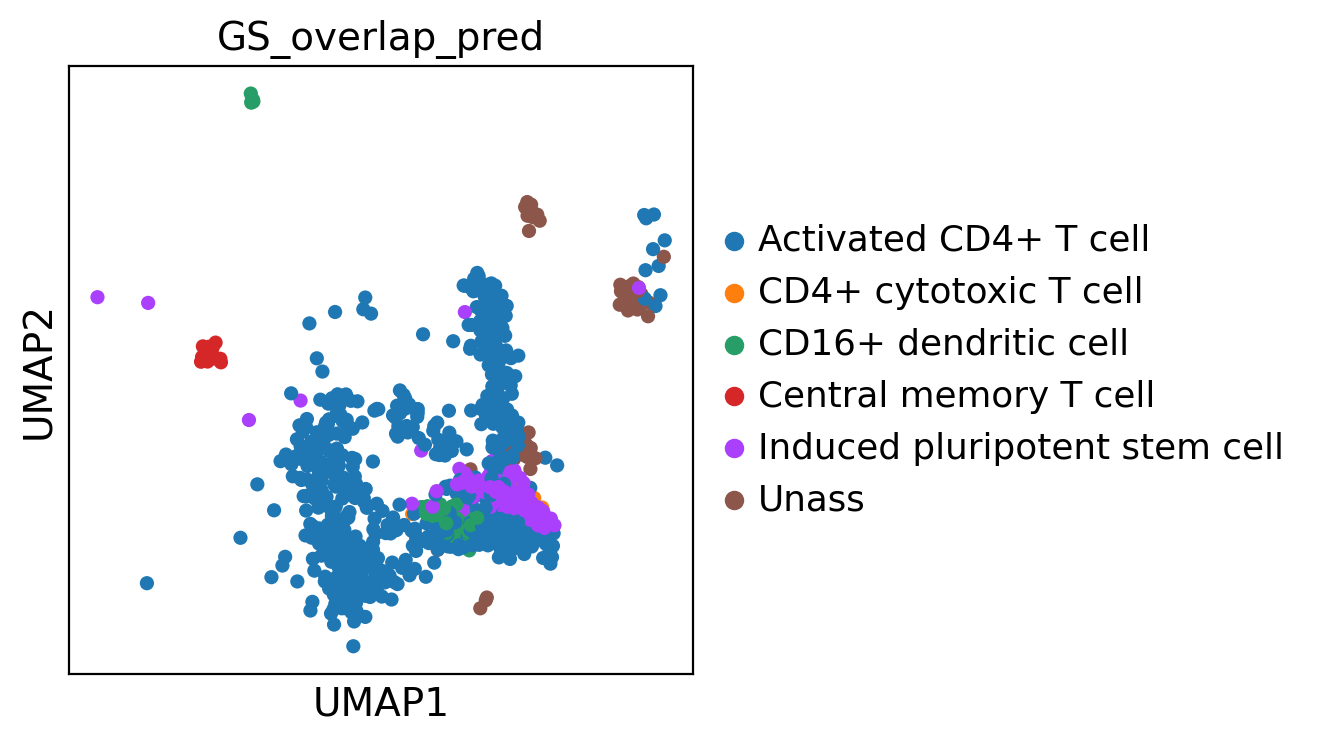

In [131]:
sc.pl.umap(adata, color='GS_overlap_pred')